In [1]:
#add library dependencies

from __future__ import print_function
import os
import pickle

import numpy as np
import time
import datetime
from functools import reduce

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from scipy.optimize import least_squares

import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

In [3]:
# for data in the TowerX_M-DD-YY format...

# 0"TIMESTAMP"
# 1"RECORD"
# 2"AWS"
# 3"AWD"
# 4"SIG"
# 5"WSStdDev"
# 6"WSGust"
# 7"WSgst_TMx"
# 8"AvgWS2"
# 9"WS2StdDev"
# 10"WS2Gust"
# 11"WS2gst_TMx"
# 12"AvgWS3"
# 13"WS3StdDev"
# 14"WS3Gust"
# 15"WS3gst_TMx"
# 16"AvgAT"
# 17"AvgRH"
# 18"AvgDP"
# 19"AvgHIdx"
# 20"AvgLBP"
# 21"AvgSLBP"
# 22"AvgST"
# 23"AvgVW"
# 24"TotPrec"
# 25"AvgPZ"
# 26"LTemp"
# 27"Batt"
# 28"AvgPM0.3"
# 29"AvgPM0.5"
# 30"AvgPM0.7"
# 31"AvgPM1"
# 32"AvgPM2"
# 33"AvgPM3"
# 34"AvgPM5"
# 35"AvgPM10"
# 36"AvgFlow"
# 37"Alarm

s_2_d = 1/(60*60*24)

In [4]:
# this is 10 min averaged data from Ryan's tower on the upwind playa, near protodunes [32.863285, -106.289875]

# path to met1 data
p10 = Path(os.getcwd()+'/Tower1/Tower1_7-17-15/Tower1_Avg10Min.dat')
p11 = Path(os.getcwd()+'/Tower1/Tower1_8-15-15/Tower1_Avg10Min_2015_08_15_08_15_22.dat')

# 2nd file for twoer1 is weird, omit for now
path = [p10,p11]
towe = [1,1]

t1 = []

a1 = []

u01 = []
u11 = []
u21 = []

T1 = []

h1 = []

for i in range(0,np.shape(path)[0]):
    tempdata = pd.read_csv(path[i],header=1)
    if towe[i]==1:
        t1  = np.append(t1,tempdata.iloc[2:,0])
        a1  = np.append(a1,tempdata.iloc[2:,3])
        u01 = np.append(u01,tempdata.iloc[2:,12])
        u11 = np.append(u11,tempdata.iloc[2:,8])
        u21 = np.append(u21,tempdata.iloc[2:,2])
        T1  = np.append(T1,tempdata.iloc[2:,16])
        
t1s = []

for i in t1:
    try:
        t1s.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        t1s.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple())))

In [5]:
# i'm only including data from Mesowest during the period full-functioning Met 1 data is available
# this is hourly-averaged data
# see https://mesowest.utah.edu/cgi-bin/droman/mesomap.cgi?state=NM&rawsflag=3

# path to Holloman data
p00 = Path(os.getcwd()+'/Holloman/KHMN.csv')

path = [p00]
towe = [0]

t0 = []

a0 = []

u20 = []

T0 = []

h0 = []

for i in range(0,np.shape(path)[0]):
    tempdata = pd.read_csv(path[i],header=6)
    if towe[i]==0:
        t0  = np.append(t0,tempdata.iloc[1:,1])
        a0  = np.append(a0,tempdata.iloc[1:,5])
        u20 = np.append(u20,tempdata.iloc[1:,4])
        T0  = np.append(T0,tempdata.iloc[1:,2])
        
t0s = []

for i in t0:
    t0s.append(int(time.mktime(datetime.datetime.strptime(i,'%m/%d/%Y %H:%M MDT').timetuple())))

In [6]:
# met1 time in seconds
t1s = np.asarray(t1s)

# met1 10m wind direction in degrees from north
a1 = np.asarray(a1,dtype=np.float)

# met1 wind speeds at 2, 5 and 10m
u01 = np.asarray(u01,dtype=np.float)
u11 = np.asarray(u11,dtype=np.float)
u21 = np.asarray(u21,dtype=np.float)

# met1 temperature
T1 = np.asarray(T1,dtype=np.float)

# holloman time in seconds
t0s = np.asarray(t0s)

# holloman 10m wind direction in degrees from north
a0 = np.asarray(a0,dtype=np.float)

# holloman 10m wind speed
u20 = np.asarray(u20,dtype=np.float)

# holloman temperature
T0 = np.asarray(T0,dtype=np.float)

In [7]:
s_2_d = 1/(60*60*24)

t1d = t1s*s_2_d
t0d = t0s*s_2_d

In [20]:
t0sc = np.empty_like(t1s)
t0sc[:] = np.nan

a0c = np.empty_like(a1)
a0c[:] = np.nan

u20c = np.empty_like(u21)
u20c[:] = np.nan

T0c = np.empty_like(T1)
T0c[:] = np.nan

# find data from holloman within the same hour as met tower 1
for i in np.arange(0,np.shape(t0s)[0]):
    closest_time = np.argmin(np.abs(t0s[i]-t1s))
    if closest_time<=60*60:
        t0sc[closest_time] = t0s[i]
        a0c[closest_time] = a0[i]
        u20c[closest_time] = u20[i]
        T0c[closest_time] = T0[i]

In [26]:
adunes = 247.5 #be more rigorous with met tower locations later
adelta = 15

u01a = []
u11a = []
u21a = []

a1a = []

u20a = []
u20ca = []

a0a = []
a0ca = []

# find data where the winds are aligned with the dune migration direction
for i in range(0,np.shape(t1s)[0]):
    if (a1[i]<adunes+adelta) & (a1[i]>adunes-adelta):
        u01a = np.append(u01a,u01[i])
        u11a = np.append(u11a,u11[i])
        u21a = np.append(u21a,u21[i])
        
        a1a = np.append(a1a,a1[i])
        
for i in range(0,np.shape(t0s)[0]):
    if (a0[i]<adunes+adelta) & (a0[i]>adunes-adelta):
        u20a = np.append(u20a,u20[i])
        
        a0a = np.append(a0a,a0[i])

In [22]:
# find friction velocity and roughness for met 1
kap = 0.38
z = np.asarray([2,5,10])

u1 = np.asarray([u01,u11,u21])
u1z = np.polyfit(np.log(z), u1,deg=1)
us1 = u1z[0]*kap
zn1 = np.exp(-u1z[0]*u1z[1])

#only use sensible data
us1r = us1[(us1>0)&(zn1<10)]
zn1r = zn1[(us1>0)&(zn1<10)]

In [23]:
# find friction velocity and roughness for met 1 when wind direction is aligned with dune migration
kap = 0.38
z = np.asarray([2,5,10])

u1a = np.asarray([u01a,u11a,u21a])
u1za = np.polyfit(np.log(z), u1a,deg=1)
us1a = u1za[0]*kap
zn1a = np.exp(-u1za[0]*u1za[1])

#only use sensible data
us1ar = us1a[(us1a>0)&(zn1a<10)]
zn1ar = zn1a[(us1a>0)&(zn1a<10)]

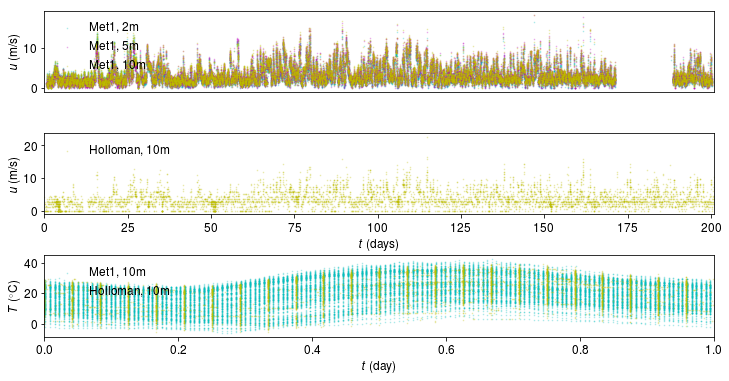

In [24]:
# time series plot to verify timezoning and data coverage

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 1
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = -45
v6 = 45

lpu1 = 0
hpu1 = 25

tdmin = np.min([np.min(t1d),np.min(t0d)])
tdmax = np.max([np.max(t1d),np.max(t0d)])

fig = plt.gcf()

ax1 = plt.subplot(311)

sc = ax1.scatter(t1d-tdmin,u01,s=S,c='c',lw=LW,alpha=A,label='Met1, 2m')
sc = ax1.scatter(t1d-tdmin,u11,s=S,c='m',lw=LW,alpha=A,label='Met1, 5m')
sc = ax1.scatter(t1d-tdmin,u21,s=S,c='y',lw=LW,alpha=A,label='Met1, 10m')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_ylabel('$u$ (m/s)',fontsize=fs)

plt.xlim(0,tdmax-tdmin)

plt.xticks([],[])

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(312)

sc = ax1.scatter(t0d-tdmin,u20,s=S,c='y',lw=LW,alpha=A,label='Holloman, 10m')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_ylabel('$u$ (m/s)',fontsize=fs)
ax1.set_xlabel('$t$ (days)',fontsize=fs)

plt.xlim(0,tdmax-tdmin)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(313)

sc = ax1.scatter((t1d-tdmin)%1,T1,s=S,c='c',lw=LW,alpha=A,label='Met1, 10m')
sc = ax1.scatter((t0d-tdmin)%1,T0,s=S,c='y',lw=LW,alpha=A,label='Holloman, 10m')

ax1.legend(loc=2,frameon=False,fontsize=fs)

ax1.set_ylabel('$T$ ($^{\\circ}$C)',fontsize=fs)
ax1.set_xlabel('$t$ (day)',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(0,1)

fig.subplots_adjust(hspace=0.5)

fig.set_size_inches(12, 6, forward=True)
# plt.savefig('some_name80.png', bbox_inches='tight',dpi=300)

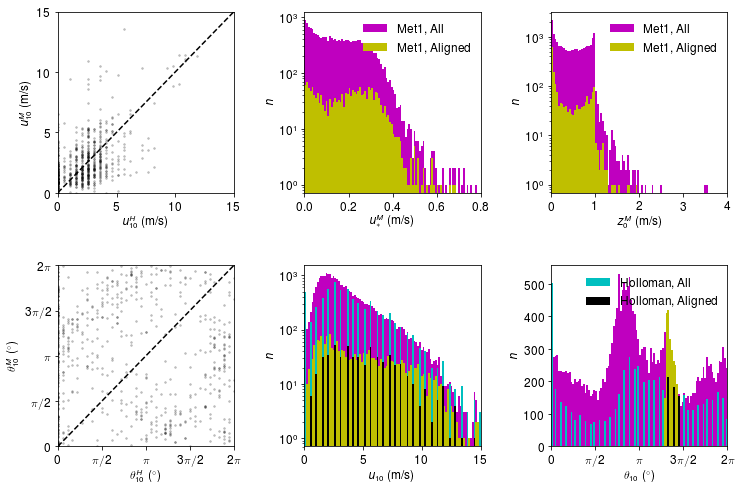

In [25]:
#plot for comparison

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 3
A = 0.2
fs = 12


fig = plt.gcf()

ax1 = plt.subplot(231)

sc = ax1.scatter(u20c,u21,s=S,c='k',lw=LW,alpha=A,label='All')
sc1 = ax1.plot([0,15],[0,15],'--',c='k',label='Equal')

ax1.set_xlabel('$u_{10}^{H}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$u_{10}^{M}$ (m/s)',fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xticks(np.linspace(0,15,4), ('0', '5', '10', '15'))
plt.yticks(np.linspace(0,15,4), ('0', '5', '10', '15'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(234)

sc = ax1.scatter(a0c*np.pi/180,a1*np.pi/180,s=S,c='k',lw=LW,alpha=A,label='All')
sc1 = ax1.plot([0,2*np.pi],[0,2*np.pi],'--',c='k',label='Equal')

ax1.set_xlabel('$\\theta_{10}^{H}$ ($^{\\circ}$)',fontsize=fs)
ax1.set_ylabel('$\\theta_{10}^{M}$ ($^{\\circ}$)',fontsize=fs)

plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)

plt.xticks(np.linspace(0,2*np.pi,5), ('0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$'))
plt.yticks(np.linspace(0,2*np.pi,5), ('0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(232)

t1 = ax1.hist(us1r,bins=100,range=[0,0.8],color='m',log=True,label='Met1, All')
t1 = ax1.hist(us1ar,bins=100,range=[0,0.8],color='y',log=True,label='Met1, Aligned')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(0,0.8)

ax1.set_xlabel('$u_{*}^{M}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

ax1 = plt.subplot(233)

t1 = ax1.hist(zn1r,bins=100,range=[0,4],color='m',log=True,label='Met1, All')
t1 = ax1.hist(zn1ar,bins=100,range=[0,4],color='y',log=True,label='Met1, Aligned')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(0,4)

ax1.set_xlabel('$z_{0}^{M}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

ax1 = plt.subplot(235)

t1 = ax1.hist(u21,bins=100,range=[0,15],color='m',log=True,label='Met1, All')
t1 = ax1.hist(u21a,bins=100,range=[0,15],color='y',log=True,label='Met1, Aligned')
t1 = ax1.hist(u20,bins=100,range=[0,15],color='c',log=True,label='Holloman, All')
t1 = ax1.hist(u20a,bins=100,range=[0,15],color='k',log=True,label='Holloman, Aligned')

ax1.set_xlabel('$u_{10}$ (m/s)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

plt.xlim(0,15)

plt.xticks(np.linspace(0,15,4), ('0', '5', '10', '15'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(236)

t1 = ax1.hist(a1*np.pi/180,bins=100,range=[0,2*np.pi],color='m')
t1 = ax1.hist(a1a*np.pi/180,bins=100,range=[0,2*np.pi],color='y')
t1 = ax1.hist(a0*np.pi/180,bins=100,range=[0,2*np.pi],color='c',label='Holloman, All')
t1 = ax1.hist(a0a*np.pi/180,bins=100,range=[0,2*np.pi],color='k',label='Holloman, Aligned')

ax1.set_xlabel('$\\theta_{10}$ ($^{\\circ}$)',fontsize=fs)
ax1.set_ylabel('$n$',fontsize=fs)

ax1.legend(loc=0,frameon=False,fontsize=fs)

plt.xlim(0,2*np.pi)

plt.xticks(np.linspace(0,2*np.pi,5), ('0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(wspace=0.4)
fig.subplots_adjust(hspace=0.4)

fig.set_size_inches(12, 8, forward=True)
plt.savefig('narteau-ewing.png', bbox_inches='tight',dpi=300)